In [1]:
from functools import partial
import numpy as np
import os
import pandas as pd
import scipy

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt


import sys
sys.path.append('../')
import util

save_fig = partial(util.save_fig, save=True)

**Default parameters - will be replaced**

In [2]:
### IGNORE THIS CELL, IT WILL BE OVERWRITTEN
dataset_file = '/home/drake/workspace/em-2020/data/combined_dataset_all_final.csv'
index_fields = ['Country', 'Year']
data_fields = ['ENI' ,'POP', 'URB', 'AFL' , 'TI', 'CTS' ,'KAOPEN']
prefix = 'template'
start_year = 2005
end_year = 2015
exclude_countries = []
pickle_file = '/home/drake/workspace/em-2020/analysis/D3_gmm/template_output.pickle.bz2'
pdynmc_params = {
    "use.mc.diff": True,
    "use.mc.lev": False,
    "use.mc.nonlin": True,
    "include.y": True,
    "varname.y": "ENI",
    "lagTerms.y": 2,
    "fur.con": True,
    "fur.con.diff": True,
    "fur.con.lev": False,
    "varname.reg.fur": ["POP", "AFL", "AFL2", "URB", "CTS", "TI", "KAOPEN"],
    "lagTerms.reg.fur": [0, 0, 0, 0, 0, 0, 0],
    "include.dum": True,
    "dum.diff": True,
    "dum.lev": False,
    "w.mat": "iid.err",
    "std.err": "corrected",
    "estimation": "iterative",
    "opt.meth": "BFGS",
    "inst.stata": False,
}
plm_formula = 'ENI ~ lag(ENI, 1:2) + POP + AFL + AFL2 + URB + CTS + TI + KAOPEN | lag(ENI, 2:99)'
plm_params = {
    'effect': 'twoways',
    'model': 'twostep',
    'collapse': False,
    'transformation': 'd',
}

In [3]:
# Parameters
dataset_file = "/home/drake/workspace/em-2020/data/combined_dataset_subset_final.csv"
index_fields = ["Country", "Year"]
data_fields = ["ENI", "POP", "URB", "AFL", "TI", "TS", "CTS", "KAOPEN"]
prefix = "template"
start_year = 1996
end_year = 2015
exclude_countries = []
pdynmc_params = {
    "use.mc.diff": True,
    "use.mc.lev": True,
    "use.mc.nonlin": False,
    "include.y": True,
    "varname.y": "ENI",
    "lagTerms.y": 2,
    "fur.con": True,
    "fur.con.diff": True,
    "fur.con.lev": False,
    "varname.reg.fur": ["POP", "AFL", "AFL2", "URB", "TS"],
    "lagTerms.reg.fur": [0, 0, 0, 0, 0],
    "include.dum": True,
    "dum.diff": True,
    "dum.lev": False,
    "w.mat": "iid.err",
    "std.err": "corrected",
    "estimation": "twostep",
    "opt.meth": "none",
    "inst.stata": False,
}
pickle_file = (
    "/home/drake/workspace/em-2020/analysis/D3_gmm/sysGMM_Rafiq2016_subset.pickle.bz2"
)


**End of parameter section** 

In [4]:
%get dataset_file index_fields data_fields start_year end_year exclude_countries 
%get pdynmc_params plm_formula plm_params

# SoS mangles dict keys, for no apparent reason
names(pdynmc_params) <- gsub('_', '.', names(pdynmc_params))
names(plm_params) <- gsub('_', '.', names(plm_params))

suppressMessages({
library(dplyr)
library(plm)
library(pdynmc)
})
`%notin%` <- Negate(`%in%`)

data.df <- subset(
    read.csv(dataset_file), select=c(index_fields, data_fields),
    subset=(Country %notin% exclude_countries) 
    & (start_year <= Year) & (Year <= end_year)
)
data.df['AFL2'] = data.df['AFL']^2
data.panel <- pdata.frame(data.df, index = c("Country", "Year"), drop.index = TRUE, row.names=TRUE)

head(data.df %>% 
    group_by(Country) %>% 
    summarize(min=min(Year), max=max(Year), .groups='drop'))

Country,min,max
<fct>,<int>,<int>
ARG,1996,2014
AUS,1996,2015
BGR,1996,2014
BRA,1996,2014
CAN,1996,2015
CHE,1996,2014


In [5]:
pdynmc_params

$use.mc.diff
[1] TRUE

$use.mc.lev
[1] TRUE

$use.mc.nonlin
[1] FALSE

$include.y
[1] TRUE

$varname.y
[1] "ENI"

$lagTerms.y
[1] 2

$fur.con
[1] TRUE

$fur.con.diff
[1] TRUE

$fur.con.lev
[1] FALSE

$varname.reg.fur
[1] "POP"  "AFL"  "AFL2" "URB"  "TS"  

$lagTerms.reg.fur
[1] 0 0 0 0 0

$include.dum
[1] TRUE

$dum.diff
[1] TRUE

$dum.lev
[1] FALSE

$w.mat
[1] "iid.err"

$std.err
[1] "corrected"

$estimation
[1] "twostep"

$opt.meth
[1] "none"

$inst.stata
[1] FALSE

In [6]:
pdynmc_base_params <- list(dat = data.df, 
                    varname.i = "Country", varname.t = "Year", varname.dum = "Year")

pdynmc_fit <- do.call(pdynmc, modifyList(pdynmc_base_params, pdynmc_params))
pdynmc_summary <- summary(pdynmc_fit)
pdynmc_summary


Dynamic linear panel estimation (twostep)
Estimation steps: 2

Coefficients:
        Estimate Std.Err.rob z-value.rob Pr(>|z.rob|)    
L1.ENI   0.25087     0.08280       3.030      0.00245 ** 
L2.ENI  -0.54321     0.53514      -1.015      0.31011    
L0.POP  -0.39620     0.30184      -1.313      0.18918    
L0.AFL   0.34168     0.13631       2.507      0.01218 *  
L0.AFL2 -0.04208     0.01067      -3.946        8e-05 ***
L0.URB   0.06988     0.03696       1.891      0.05862 .  
L0.TS    0.13536     0.11188       1.210      0.22628    
1999    -0.02616     0.02475      -1.057      0.29051    
2000    -0.05179     0.02965      -1.746      0.08081 .  
2001    -0.06331     0.03499      -1.809      0.07045 .  
2002    -0.09337     0.05598      -1.668      0.09532 .  
2003    -0.10075     0.06286      -1.603      0.10893    
2004    -0.12240     0.08078      -1.515      0.12977    
2005    -0.14042     0.08384      -1.675      0.09393 .  
2006    -0.18415     0.09974      -1.846      0.0648


Call:
lm(formula = residuals ~ fitted, data = pdynmc_resid)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.4351 -0.1681  0.1441  0.1950  0.8734 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.16232    0.02218  -7.318 6.47e-13 ***
fitted      -0.05026    0.01599  -3.144  0.00173 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4385 on 752 degrees of freedom
  (16 observations deleted due to missingness)
Multiple R-squared:  0.01297,	Adjusted R-squared:  0.01166 
F-statistic: 9.883 on 1 and 752 DF,  p-value: 0.001733


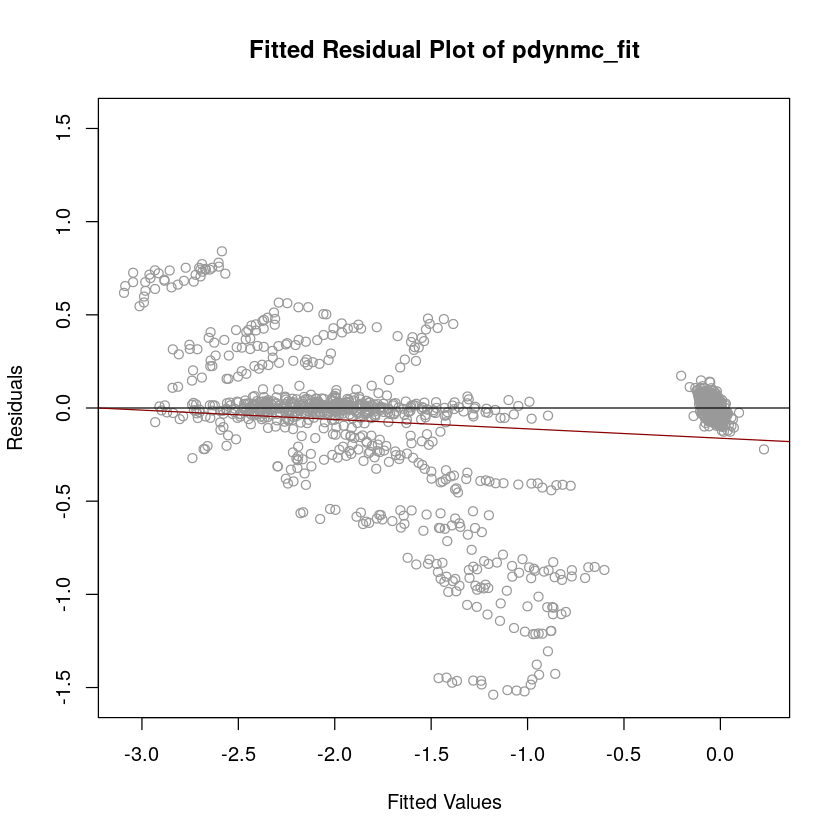

In [7]:
pdynmc_resid <- data.frame(residuals=unlist(residuals(pdynmc_fit)),
                           fitted=unlist(fitted.values(pdynmc_fit)))
resid.reg <- lm(residuals ~ fitted, data=pdynmc_resid)
plot(pdynmc_fit)
abline(resid.reg, col='darkred')
summary(resid.reg)

In [8]:
jtest.fct(pdynmc_fit)
ser.corr1 <- mtest.fct(pdynmc_fit, t.order = 1)
ser.corr1
ser.corr2 <- mtest.fct(pdynmc_fit, t.order = 2)
ser.corr2


	J-Test of Hansen

data:  2step GMM Estimation; H0: overidentifying restrictions valid
chisq = 9.905e-06, df = 186, p-value = 1



	Arrelano and Bond (1991) serial correlation test of degree 1

data:  2step GMM Estimation; H0: no serial correlation of order 1 in the error terms
normal = 1.6407, p-value = 0.1009



	Arrelano and Bond (1991) serial correlation test of degree 2

data:  2step GMM Estimation; H0: no serial correlation of order 2 in the error terms
normal = 1.6399, p-value = 0.101


In [9]:
pdynmc_tests <- do.call(rbind, lapply(
    list(pdynmc_summary$hansenj, pdynmc_summary$slopef, pdynmc_summary$time.dumf, ser.corr1, ser.corr2),
    function(x) {
        data.frame(stat=as.numeric(x$statistic), test=names(x$statistic),
                   p.value=x$p.value, row.names=x$method, result=x$data.name)
    }
))
pdynmc_tests

,stat,test,p.value,result
,<dbl>,<fct>,<dbl>,<fct>
J-Test of Hansen,9.905049e-06,chisq,1.000000e+00,2step GMM Estimation; H0: overidentifying restrictions valid
Wald test,1.432985e+04,chisq,0.000000e+00,2step GMM Estimation; H0: slope parameters are jointly zero
Wald test1,1.349030e+02,chisq,2.121966e-20,2step GMM Estimation; H0: time.dum parameters are jointly zero
Arrelano and Bond (1991) serial correlation test of degree 1,1.640698e+00,normal,1.008601e-01,2step GMM Estimation; H0: no serial correlation of order 1 in the error terms
Arrelano and Bond (1991) serial correlation test of degree 2,1.639916e+00,normal,1.010226e-01,2step GMM Estimation; H0: no serial correlation of order 2 in the error terms


In [10]:
# plm.formula <- as.formula(plm_formula)
# plm.params = modifyList(list(plm.formula,
#                              data=data.panel),
#                         plm_params)
# z2 <- do.call(pgmm, plm.params)
# z2$call <- plm.formula
# summary(z2, robust = TRUE)

In [11]:
pdynmc_coef <- data.frame(pdynmc_summary$coefficients)

In [12]:
%get pdynmc_coef pdynmc_tests pdynmc_resid --from R
import pickle
import bz2

with bz2.BZ2File(pickle_file, 'w') as fd:
    pickle.dump({
        'pdynmc_coef': pdynmc_coef,
        'pdynmc_tests': pdynmc_tests,
        'pdynmc_resid': pdynmc_resid,
        'pdynmc_params': pdynmc_params,
        'start_year': start_year,
        'end_year': end_year,
    }, fd)